# Installing Libraries & Loading .csv Data

In [3]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

2024-05-08 01:36:12.858175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 01:36:12.858304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 01:36:12.861430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 01:36:13.142580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 01:36:15.106267: W tensorflow/compiler/

In [4]:
# Had to work around a "Error tokenizing error", specifically modifying parser engine to python
data = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv'), engine="python")

In [5]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [22]:
print(data.shape)

(159571, 8)


In [25]:
# For this particular dataset, notice that each comment is uniquely identified with the 'id' column, but more importantly, each comment contains labels specifying different types of toxicities that a comment could have.

# Data Preprocessing

In [6]:
# Utilizing tensorflow's in-built vectorization tool to tokenize our data values.
from tensorflow.keras.layers import TextVectorization

In [8]:
# Splitting by comments and their corresponding toxicity labels
x = data['comment_text']
y = data[data.columns[2:]].values

In [9]:
# Higher -> possibly more accurate but slower model
MAX_WORDS = 200000

In [10]:
# Capping model to only take max 1800 tokens per comment
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

2024-05-08 01:36:42.087350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
# All words/tokens within our comments data is learned by the vectorizer
vectorizer.adapt(x.values)

# vectorized_text now contains the translated comments to our custom vectorizer (represented as integers)
vectorized_text = vectorizer(x.values)

In [12]:
# Creating data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
# Creating traning, validation and testing dataset splits
# 70% training, 20% validation, 10% testing
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Sequential (Deep Learning) Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
# Create base sequential model
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional (allows for two-way information passing, important for sentence cohesion in analysis) LSTM Layer, 'tanh' activation needed for LSTM layers
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer, 6 for the number of toxicity labels, sigmoid converts outputs to ranges between 0-1 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
model_training = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 3054s 437ms/step - loss: 0.0634 - val_loss: 0.0448


<Figure size 800x500 with 0 Axes>

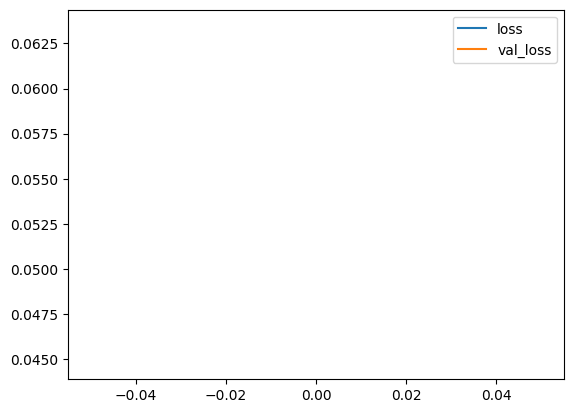

In [19]:
# Won't actually plot anything, need more epochs
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(model_training.history).plot()
plt.show()

# Predictions Test

In [38]:
input_text = vectorizer('You suck so much dude.')

In [39]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 45ms/step


In [33]:
data.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [40]:
# We set a 0.5 threshhold value to determine if the label is accurate for our input text
# Simplifying analysis by using binary values
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

# Evaluating Model

In [41]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [42]:
# Evaluating accuracy of our model with various metrics
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [45]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8408516645431519, Recall:0.6608054637908936, Accuracy:0.46339017152786255


# Visualizing a UI platform to Test

In [47]:
!pip install gradio jinja2

In [48]:
import tensorflow as tf
import gradio as gr

In [49]:
model.save('gradio.app')

INFO:tensorflow:Assets written to: gradio.app/assets


INFO:tensorflow:Assets written to: gradio.app/assets


In [50]:
model = tf.keras.models.load_model('gradio.app')

In [52]:
# Function to pass into gradio app to utilize our model, similar format to the testing we did earlier
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [53]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/tmp/ipykernel_2089237/2358991581.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
/tmp/ipykernel_2089237/2358991581.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
/tmp/ipykernel_2089237/2358991581.py:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),


IMPORTANT: You are using gradio version 3.47.1, however version 4.29.0 is available, please upgrade.
--------


In [56]:
interface.launch(share=True)